In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer
import os.path
# Harmonization
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel
from sklearn.utils import shuffle

ModuleNotFoundError: No module named 'afqinsight'

In [2]:
from afqinsight.augmentation import jitter, time_warp, scaling

In [3]:
def augment_this(X, y, rounds=2): 
    new_X = X[:]
    new_y = y[:]
    for f in range(rounds): 
        aug_X = np.zeros_like(X)
        # Do each channel separately:
        for channel in range(aug_X.shape[-1]):
            this_X = X[..., channel][..., np.newaxis]
            this_X = jitter(this_X, sigma=np.mean(this_X)/25)
            this_X = scaling(this_X, sigma=np.mean(this_X)/25)
            this_X = time_warp(this_X, sigma=np.mean(this_X)/25)
            aug_X[..., channel] = this_X[...,0]
        new_X = np.concatenate([new_X, aug_X])
        new_y = np.concatenate([new_y, y])
    return new_X, new_y 

In [51]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [52]:
afq_dataset.drop_target_na()

In [53]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 7200)
(1865, 3)


In [56]:
afq_dataset.subjects

['sub-NDARAA306NT2',
 'sub-NDARAA536PTU',
 'sub-NDARAA947ZG5',
 'sub-NDARAA948VFH',
 'sub-NDARAB055BPR',
 'sub-NDARAB348EWR',
 'sub-NDARAB458VK9',
 'sub-NDARAB514MAJ',
 'sub-NDARAB708LM5',
 'sub-NDARAB977GFB',
 'sub-NDARAC349YUC',
 'sub-NDARAC350BZ0',
 'sub-NDARAC350XUM',
 'sub-NDARAC462DZH',
 'sub-NDARAC495TJ2',
 'sub-NDARAC853CR6',
 'sub-NDARAC853DTE',
 'sub-NDARAC857HDB',
 'sub-NDARAD224CRB',
 'sub-NDARAD232HVV',
 'sub-NDARAD481FXF',
 'sub-NDARAD571FLB',
 'sub-NDARAD615WLJ',
 'sub-NDARAD703XA2',
 'sub-NDARAE199TDD',
 'sub-NDARAE270LEZ',
 'sub-NDARAE358VBE',
 'sub-NDARAE877NER',
 'sub-NDARAF440XWG',
 'sub-NDARAF535XK6',
 'sub-NDARAG115LZP',
 'sub-NDARAG191AE8',
 'sub-NDARAG610XL4',
 'sub-NDARAH304ED7',
 'sub-NDARAH503YG1',
 'sub-NDARAH793FBF',
 'sub-NDARAJ366ZFA',
 'sub-NDARAJ689BVN',
 'sub-NDARAK019ZR6',
 'sub-NDARAK738BGC',
 'sub-NDARAL828WXM',
 'sub-NDARAL897CYV',
 'sub-NDARAM277WZT',
 'sub-NDARAM357BUA',
 'sub-NDARAM675UR8',
 'sub-NDARAM848GTE',
 'sub-NDARAN076TPG',
 'sub-NDARAN2

In [7]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

2022-04-12 21:15:36.498153: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

In [9]:
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

In [10]:
print(site.shape)
print(X.shape)
print(y.shape)

(1817,)
(1817, 100, 72)
(1817,)


In [11]:
import seaborn as sns
import pandas as pd

In [12]:
data = pd.DataFrame(dict(age=y, site=site))

<AxesSubplot:xlabel='age', ylabel='Count'>

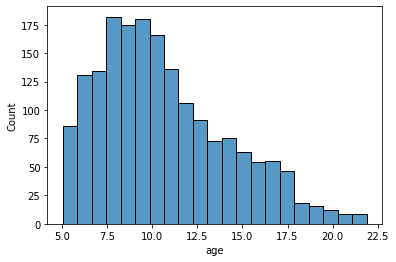

In [13]:
sns.histplot(data=data, x="age")

<AxesSubplot:xlabel='site', ylabel='Count'>

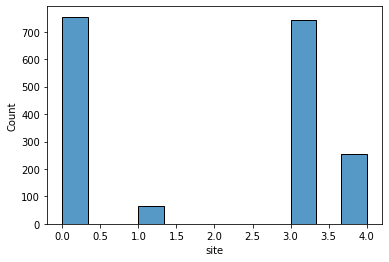

In [14]:
sns.histplot(data=data, x="site")

<AxesSubplot:xlabel='age', ylabel='Count'>

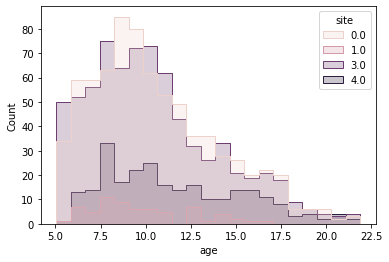

In [15]:
sns.histplot(data=data, x="age", hue="site", element='step')

In [16]:
age_groups = (y/4).astype(int)

In [17]:
X0 = X[site==0]
X1 = X[site==1]
X3 = X[site==3]
X4 = X[site==4]

y0 = y[site==0]
y1 = y[site==1]
y3 = y[site==3]
y4 = y[site==4]

age_groups0 = age_groups[site==0]
age_groups1 = age_groups[site==1]
age_groups3 = age_groups[site==3]
age_groups4 = age_groups[site==4]

In [18]:
X0.shape, y0.shape

((755, 100, 72), (755,))

In [19]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, stratify=age_groups0, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, stratify=age_groups1, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, stratify=age_groups3, random_state=42)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, stratify=age_groups4, random_state=42)

In [20]:
X0_train.shape, X1_train.shape, X3_train.shape, X4_train.shape

((604, 100, 72), (52, 100, 72), (594, 100, 72), (202, 100, 72))

In [21]:
imputer = SimpleImputer(strategy="median")

In [22]:
def impute(X_train, X_test):
    X_train = np.concatenate([imputer.fit_transform(X_train[..., ii])[:, :, None] for ii in range(X_train.shape[-1])], -1)
    X_test = np.concatenate([imputer.fit_transform(X_test[..., ii])[:, :, None] for ii in range(X_test.shape[-1])], -1)
    return X_train, X_test

In [23]:
X0_train, X0_test = impute(X0_train, X0_test)
X1_train, X1_test = impute(X1_train, X1_test)
X3_train, X3_test = impute(X3_train, X3_test)
X4_train, X4_test = impute(X4_train, X4_test)

In [24]:
X0_train.shape

(604, 100, 72)

In [25]:
n_epochs = 1000

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    mode="min",
    patience=100
)

# ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=20,
    verbose=1,
)

In [26]:
model_name=cnn_resnet
lr = 0.01
ckpt_filepath = '/Users/arokem/tmp/chkpt.h5'

In [27]:
X0_train.shape

(604, 100, 72)

In [28]:
this_X0_train, this_y0_train = shuffle(X0_train, y0_train, n_samples=404)

In [29]:
this_X0_train, this_y0_train = augment_this(this_X0_train, this_y0_train)

In [30]:
this_X0_train, this_y0_train = shuffle(this_X0_train, this_y0_train)

In [31]:
log = tf.keras.callbacks.CSVLogger(filename=(str(model_name) + '.csv'), append=True)

model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error'])


ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

callbacks = [early_stopping, ckpt, reduce_lr]
history = model.fit(this_X0_train, this_y0_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                    callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 64)      36928       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 64)      0           ['batch_normalization[0][0]']

8/8 [==============================] - ETA: 0s - loss: 46.4827 - mean_squared_error: 46.4827 - rmse: 6.8178 - mean_absolute_error: 5.4212
Epoch 00001: val_loss improved from inf to 1532178816.00000, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 4s 294ms/step - loss: 46.4827 - mean_squared_error: 46.4827 - rmse: 6.8178 - mean_absolute_error: 5.4212 - val_loss: 1532178816.0000 - val_mean_squared_error: 1532178816.0000 - val_rmse: 39143.0547 - val_mean_absolute_error: 39053.6484 - lr: 0.0100
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 8.7123 - mean_squared_error: 8.7123 - rmse: 2.9517 - mean_absolute_error: 2.4100
Epoch 00002: val_loss improved from 1532178816.00000 to 643678016.00000, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 259ms/step - loss: 8.7123 - mean_squared_error: 8.7123 - rmse: 2.9517 - mean_absolute_error: 2.4100 - val_loss: 643678016.0000 - val_mean_squared_error: 643678016.

8/8 [==============================] - ETA: 0s - loss: 1.3186 - mean_squared_error: 1.3186 - rmse: 1.1483 - mean_absolute_error: 0.8932
Epoch 00017: val_loss did not improve from 10.11156
8/8 [==============================] - 2s 279ms/step - loss: 1.3186 - mean_squared_error: 1.3186 - rmse: 1.1483 - mean_absolute_error: 0.8932 - val_loss: 13.6164 - val_mean_squared_error: 13.6164 - val_rmse: 3.6900 - val_mean_absolute_error: 2.9330 - lr: 0.0100
Epoch 18/1000
8/8 [==============================] - ETA: 0s - loss: 1.2353 - mean_squared_error: 1.2353 - rmse: 1.1114 - mean_absolute_error: 0.8586
Epoch 00018: val_loss did not improve from 10.11156
8/8 [==============================] - 2s 279ms/step - loss: 1.2353 - mean_squared_error: 1.2353 - rmse: 1.1114 - mean_absolute_error: 0.8586 - val_loss: 107.1946 - val_mean_squared_error: 107.1946 - val_rmse: 10.3535 - val_mean_absolute_error: 9.6459 - lr: 0.0100
Epoch 19/1000
8/8 [==============================] - ETA: 0s - loss: 1.2938 - mean_

Epoch 35/1000
8/8 [==============================] - ETA: 0s - loss: 0.5373 - mean_squared_error: 0.5373 - rmse: 0.7330 - mean_absolute_error: 0.5542
Epoch 00035: val_loss did not improve from 5.36176
8/8 [==============================] - 2s 285ms/step - loss: 0.5373 - mean_squared_error: 0.5373 - rmse: 0.7330 - mean_absolute_error: 0.5542 - val_loss: 7.9301 - val_mean_squared_error: 7.9301 - val_rmse: 2.8160 - val_mean_absolute_error: 2.3534 - lr: 0.0100
Epoch 36/1000
8/8 [==============================] - ETA: 0s - loss: 0.6279 - mean_squared_error: 0.6279 - rmse: 0.7924 - mean_absolute_error: 0.5971
Epoch 00036: val_loss did not improve from 5.36176
8/8 [==============================] - 2s 274ms/step - loss: 0.6279 - mean_squared_error: 0.6279 - rmse: 0.7924 - mean_absolute_error: 0.5971 - val_loss: 5.3844 - val_mean_squared_error: 5.3844 - val_rmse: 2.3204 - val_mean_absolute_error: 1.8408 - lr: 0.0100
Epoch 37/1000
8/8 [==============================] - ETA: 0s - loss: 0.4368 - 

Epoch 53/1000
8/8 [==============================] - ETA: 0s - loss: 0.3346 - mean_squared_error: 0.3346 - rmse: 0.5784 - mean_absolute_error: 0.4578
Epoch 00053: val_loss did not improve from 3.76915
8/8 [==============================] - 2s 265ms/step - loss: 0.3346 - mean_squared_error: 0.3346 - rmse: 0.5784 - mean_absolute_error: 0.4578 - val_loss: 3.9355 - val_mean_squared_error: 3.9355 - val_rmse: 1.9838 - val_mean_absolute_error: 1.5919 - lr: 0.0100
Epoch 54/1000
8/8 [==============================] - ETA: 0s - loss: 0.3201 - mean_squared_error: 0.3201 - rmse: 0.5658 - mean_absolute_error: 0.4343
Epoch 00054: val_loss did not improve from 3.76915
8/8 [==============================] - 2s 268ms/step - loss: 0.3201 - mean_squared_error: 0.3201 - rmse: 0.5658 - mean_absolute_error: 0.4343 - val_loss: 4.2776 - val_mean_squared_error: 4.2776 - val_rmse: 2.0682 - val_mean_absolute_error: 1.6911 - lr: 0.0100
Epoch 55/1000
8/8 [==============================] - ETA: 0s - loss: 0.2610 - 

Epoch 71/1000
8/8 [==============================] - ETA: 0s - loss: 0.3622 - mean_squared_error: 0.3622 - rmse: 0.6019 - mean_absolute_error: 0.4698
Epoch 00071: val_loss did not improve from 3.23441
8/8 [==============================] - 2s 267ms/step - loss: 0.3622 - mean_squared_error: 0.3622 - rmse: 0.6019 - mean_absolute_error: 0.4698 - val_loss: 12.4967 - val_mean_squared_error: 12.4967 - val_rmse: 3.5351 - val_mean_absolute_error: 2.9546 - lr: 0.0100
Epoch 72/1000
8/8 [==============================] - ETA: 0s - loss: 0.2350 - mean_squared_error: 0.2350 - rmse: 0.4847 - mean_absolute_error: 0.3801
Epoch 00072: val_loss did not improve from 3.23441
8/8 [==============================] - 2s 266ms/step - loss: 0.2350 - mean_squared_error: 0.2350 - rmse: 0.4847 - mean_absolute_error: 0.3801 - val_loss: 3.8309 - val_mean_squared_error: 3.8309 - val_rmse: 1.9573 - val_mean_absolute_error: 1.5815 - lr: 0.0100
Epoch 73/1000
8/8 [==============================] - ETA: 0s - loss: 0.3318 

Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 0.5173 - mean_squared_error: 0.5173 - rmse: 0.7193 - mean_absolute_error: 0.5512
Epoch 00089: val_loss did not improve from 2.99014
8/8 [==============================] - 2s 268ms/step - loss: 0.5173 - mean_squared_error: 0.5173 - rmse: 0.7193 - mean_absolute_error: 0.5512 - val_loss: 4.9223 - val_mean_squared_error: 4.9223 - val_rmse: 2.2186 - val_mean_absolute_error: 1.6695 - lr: 0.0100
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 0.3835 - mean_squared_error: 0.3835 - rmse: 0.6193 - mean_absolute_error: 0.4981
Epoch 00090: val_loss did not improve from 2.99014
8/8 [==============================] - 2s 271ms/step - loss: 0.3835 - mean_squared_error: 0.3835 - rmse: 0.6193 - mean_absolute_error: 0.4981 - val_loss: 3.0670 - val_mean_squared_error: 3.0670 - val_rmse: 1.7513 - val_mean_absolute_error: 1.3517 - lr: 0.0100
Epoch 91/1000
8/8 [==============================] - ETA: 0s - loss: 0.3818 - 

8/8 [==============================] - ETA: 0s - loss: 0.1365 - mean_squared_error: 0.1365 - rmse: 0.3694 - mean_absolute_error: 0.2889
Epoch 00106: val_loss did not improve from 1.92152
8/8 [==============================] - 2s 273ms/step - loss: 0.1365 - mean_squared_error: 0.1365 - rmse: 0.3694 - mean_absolute_error: 0.2889 - val_loss: 2.0314 - val_mean_squared_error: 2.0314 - val_rmse: 1.4253 - val_mean_absolute_error: 1.0644 - lr: 0.0050
Epoch 107/1000
8/8 [==============================] - ETA: 0s - loss: 0.1993 - mean_squared_error: 0.1993 - rmse: 0.4464 - mean_absolute_error: 0.3594
Epoch 00107: val_loss did not improve from 1.92152
8/8 [==============================] - 2s 268ms/step - loss: 0.1993 - mean_squared_error: 0.1993 - rmse: 0.4464 - mean_absolute_error: 0.3594 - val_loss: 3.3682 - val_mean_squared_error: 3.3682 - val_rmse: 1.8353 - val_mean_absolute_error: 1.3426 - lr: 0.0050
Epoch 108/1000
8/8 [==============================] - ETA: 0s - loss: 0.2715 - mean_squared

Epoch 124/1000
8/8 [==============================] - ETA: 0s - loss: 0.1272 - mean_squared_error: 0.1272 - rmse: 0.3566 - mean_absolute_error: 0.2841
Epoch 00124: val_loss did not improve from 1.50019
8/8 [==============================] - 2s 275ms/step - loss: 0.1272 - mean_squared_error: 0.1272 - rmse: 0.3566 - mean_absolute_error: 0.2841 - val_loss: 2.2825 - val_mean_squared_error: 2.2825 - val_rmse: 1.5108 - val_mean_absolute_error: 1.1754 - lr: 0.0050
Epoch 125/1000
8/8 [==============================] - ETA: 0s - loss: 0.1136 - mean_squared_error: 0.1136 - rmse: 0.3371 - mean_absolute_error: 0.2591
Epoch 00125: val_loss did not improve from 1.50019
8/8 [==============================] - 2s 279ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - rmse: 0.3371 - mean_absolute_error: 0.2591 - val_loss: 1.8766 - val_mean_squared_error: 1.8766 - val_rmse: 1.3699 - val_mean_absolute_error: 1.0551 - lr: 0.0050
Epoch 126/1000
8/8 [==============================] - ETA: 0s - loss: 0.1781

Epoch 142/1000
8/8 [==============================] - ETA: 0s - loss: 0.1355 - mean_squared_error: 0.1355 - rmse: 0.3681 - mean_absolute_error: 0.2811
Epoch 00142: val_loss did not improve from 1.50019

Epoch 00142: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
8/8 [==============================] - 2s 267ms/step - loss: 0.1355 - mean_squared_error: 0.1355 - rmse: 0.3681 - mean_absolute_error: 0.2811 - val_loss: 1.7306 - val_mean_squared_error: 1.7306 - val_rmse: 1.3155 - val_mean_absolute_error: 1.0217 - lr: 0.0050
Epoch 143/1000
8/8 [==============================] - ETA: 0s - loss: 0.2637 - mean_squared_error: 0.2637 - rmse: 0.5135 - mean_absolute_error: 0.3648
Epoch 00143: val_loss did not improve from 1.50019
8/8 [==============================] - 2s 263ms/step - loss: 0.2637 - mean_squared_error: 0.2637 - rmse: 0.5135 - mean_absolute_error: 0.3648 - val_loss: 1.9291 - val_mean_squared_error: 1.9291 - val_rmse: 1.3889 - val_mean_absolute_error: 1.0681 - lr: 0.

8/8 [==============================] - ETA: 0s - loss: 0.1424 - mean_squared_error: 0.1424 - rmse: 0.3773 - mean_absolute_error: 0.3223
Epoch 00159: val_loss did not improve from 1.41772
8/8 [==============================] - 2s 275ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - rmse: 0.3773 - mean_absolute_error: 0.3223 - val_loss: 1.4820 - val_mean_squared_error: 1.4820 - val_rmse: 1.2174 - val_mean_absolute_error: 0.9279 - lr: 0.0025
Epoch 160/1000
8/8 [==============================] - ETA: 0s - loss: 0.2217 - mean_squared_error: 0.2217 - rmse: 0.4708 - mean_absolute_error: 0.3774
Epoch 00160: val_loss did not improve from 1.41772
8/8 [==============================] - 2s 311ms/step - loss: 0.2217 - mean_squared_error: 0.2217 - rmse: 0.4708 - mean_absolute_error: 0.3774 - val_loss: 1.6777 - val_mean_squared_error: 1.6777 - val_rmse: 1.2953 - val_mean_absolute_error: 0.9616 - lr: 0.0025
Epoch 161/1000
8/8 [==============================] - ETA: 0s - loss: 0.2038 - mean_squared

Epoch 177/1000
8/8 [==============================] - ETA: 0s - loss: 0.1708 - mean_squared_error: 0.1708 - rmse: 0.4133 - mean_absolute_error: 0.3173
Epoch 00177: val_loss did not improve from 1.41772
8/8 [==============================] - 2s 269ms/step - loss: 0.1708 - mean_squared_error: 0.1708 - rmse: 0.4133 - mean_absolute_error: 0.3173 - val_loss: 1.5277 - val_mean_squared_error: 1.5277 - val_rmse: 1.2360 - val_mean_absolute_error: 0.9144 - lr: 0.0012
Epoch 178/1000
8/8 [==============================] - ETA: 0s - loss: 0.1179 - mean_squared_error: 0.1179 - rmse: 0.3434 - mean_absolute_error: 0.2779
Epoch 00178: val_loss improved from 1.41772 to 1.35525, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 287ms/step - loss: 0.1179 - mean_squared_error: 0.1179 - rmse: 0.3434 - mean_absolute_error: 0.2779 - val_loss: 1.3552 - val_mean_squared_error: 1.3552 - val_rmse: 1.1642 - val_mean_absolute_error: 0.8700 - lr: 0.0012
Epoch 179/1000
8/8 [========

Epoch 195/1000
8/8 [==============================] - ETA: 0s - loss: 0.2025 - mean_squared_error: 0.2025 - rmse: 0.4500 - mean_absolute_error: 0.3358
Epoch 00195: val_loss did not improve from 1.32967
8/8 [==============================] - 2s 282ms/step - loss: 0.2025 - mean_squared_error: 0.2025 - rmse: 0.4500 - mean_absolute_error: 0.3358 - val_loss: 1.3697 - val_mean_squared_error: 1.3697 - val_rmse: 1.1703 - val_mean_absolute_error: 0.8851 - lr: 0.0012
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 0.2230 - mean_squared_error: 0.2230 - rmse: 0.4722 - mean_absolute_error: 0.3503
Epoch 00196: val_loss did not improve from 1.32967
8/8 [==============================] - 2s 279ms/step - loss: 0.2230 - mean_squared_error: 0.2230 - rmse: 0.4722 - mean_absolute_error: 0.3503 - val_loss: 1.3391 - val_mean_squared_error: 1.3391 - val_rmse: 1.1572 - val_mean_absolute_error: 0.8689 - lr: 0.0012
Epoch 197/1000
8/8 [==============================] - ETA: 0s - loss: 0.1196

Epoch 213/1000
8/8 [==============================] - ETA: 0s - loss: 0.0696 - mean_squared_error: 0.0696 - rmse: 0.2637 - mean_absolute_error: 0.2135
Epoch 00213: val_loss did not improve from 1.32967
8/8 [==============================] - 2s 298ms/step - loss: 0.0696 - mean_squared_error: 0.0696 - rmse: 0.2637 - mean_absolute_error: 0.2135 - val_loss: 1.4032 - val_mean_squared_error: 1.4032 - val_rmse: 1.1846 - val_mean_absolute_error: 0.8797 - lr: 6.2500e-04
Epoch 214/1000
8/8 [==============================] - ETA: 0s - loss: 0.0894 - mean_squared_error: 0.0894 - rmse: 0.2989 - mean_absolute_error: 0.2285
Epoch 00214: val_loss did not improve from 1.32967
8/8 [==============================] - 2s 294ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - rmse: 0.2989 - mean_absolute_error: 0.2285 - val_loss: 1.3645 - val_mean_squared_error: 1.3645 - val_rmse: 1.1681 - val_mean_absolute_error: 0.8721 - lr: 6.2500e-04
Epoch 215/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 0.0414 - mean_squared_error: 0.0414 - rmse: 0.2035 - mean_absolute_error: 0.1554
Epoch 00231: val_loss did not improve from 1.29953
8/8 [==============================] - 2s 273ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - rmse: 0.2035 - mean_absolute_error: 0.1554 - val_loss: 1.3423 - val_mean_squared_error: 1.3423 - val_rmse: 1.1586 - val_mean_absolute_error: 0.8848 - lr: 6.2500e-04
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 0.0446 - mean_squared_error: 0.0446 - rmse: 0.2111 - mean_absolute_error: 0.1762
Epoch 00232: val_loss did not improve from 1.29953
8/8 [==============================] - 2s 278ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - rmse: 0.2111 - mean_absolute_error: 0.1762 - val_loss: 1.3097 - val_mean_squared_error: 1.3097 - val_rmse: 1.1444 - val_mean_absolute_error: 0.8815 - lr: 6.2500e-04
Epoch 233/1000
8/8 [==============================] - ETA: 0s - loss

8/8 [==============================] - ETA: 0s - loss: 0.0424 - mean_squared_error: 0.0424 - rmse: 0.2060 - mean_absolute_error: 0.1616
Epoch 00248: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 275ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - rmse: 0.2060 - mean_absolute_error: 0.1616 - val_loss: 1.3551 - val_mean_squared_error: 1.3551 - val_rmse: 1.1641 - val_mean_absolute_error: 0.8697 - lr: 3.1250e-04
Epoch 249/1000
8/8 [==============================] - ETA: 0s - loss: 0.1368 - mean_squared_error: 0.1368 - rmse: 0.3698 - mean_absolute_error: 0.2752
Epoch 00249: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 267ms/step - loss: 0.1368 - mean_squared_error: 0.1368 - rmse: 0.3698 - mean_absolute_error: 0.2752 - val_loss: 1.3177 - val_mean_squared_error: 1.3177 - val_rmse: 1.1479 - val_mean_absolute_error: 0.8594 - lr: 3.1250e-04
Epoch 250/1000
8/8 [==============================] - ETA: 0s - loss: 0.1003 - mean

Epoch 266/1000
8/8 [==============================] - ETA: 0s - loss: 0.1422 - mean_squared_error: 0.1422 - rmse: 0.3771 - mean_absolute_error: 0.3320
Epoch 00266: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 275ms/step - loss: 0.1422 - mean_squared_error: 0.1422 - rmse: 0.3771 - mean_absolute_error: 0.3320 - val_loss: 1.3304 - val_mean_squared_error: 1.3304 - val_rmse: 1.1534 - val_mean_absolute_error: 0.8675 - lr: 1.5625e-04
Epoch 267/1000
8/8 [==============================] - ETA: 0s - loss: 0.0910 - mean_squared_error: 0.0910 - rmse: 0.3017 - mean_absolute_error: 0.2353
Epoch 00267: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 280ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - rmse: 0.3017 - mean_absolute_error: 0.2353 - val_loss: 1.3029 - val_mean_squared_error: 1.3029 - val_rmse: 1.1414 - val_mean_absolute_error: 0.8610 - lr: 1.5625e-04
Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 284/1000
8/8 [==============================] - ETA: 0s - loss: 0.1119 - mean_squared_error: 0.1119 - rmse: 0.3344 - mean_absolute_error: 0.2477
Epoch 00284: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 272ms/step - loss: 0.1119 - mean_squared_error: 0.1119 - rmse: 0.3344 - mean_absolute_error: 0.2477 - val_loss: 1.3035 - val_mean_squared_error: 1.3035 - val_rmse: 1.1417 - val_mean_absolute_error: 0.8611 - lr: 7.8125e-05
Epoch 285/1000
8/8 [==============================] - ETA: 0s - loss: 0.0460 - mean_squared_error: 0.0460 - rmse: 0.2144 - mean_absolute_error: 0.1622
Epoch 00285: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 279ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - rmse: 0.2144 - mean_absolute_error: 0.1622 - val_loss: 1.3104 - val_mean_squared_error: 1.3104 - val_rmse: 1.1447 - val_mean_absolute_error: 0.8623 - lr: 7.8125e-05
Epoch 286/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 302/1000
8/8 [==============================] - ETA: 0s - loss: 0.1192 - mean_squared_error: 0.1192 - rmse: 0.3452 - mean_absolute_error: 0.2693
Epoch 00302: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 288ms/step - loss: 0.1192 - mean_squared_error: 0.1192 - rmse: 0.3452 - mean_absolute_error: 0.2693 - val_loss: 1.2906 - val_mean_squared_error: 1.2906 - val_rmse: 1.1360 - val_mean_absolute_error: 0.8550 - lr: 3.9062e-05
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 0.0953 - mean_squared_error: 0.0953 - rmse: 0.3087 - mean_absolute_error: 0.2581
Epoch 00303: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 279ms/step - loss: 0.0953 - mean_squared_error: 0.0953 - rmse: 0.3087 - mean_absolute_error: 0.2581 - val_loss: 1.2896 - val_mean_squared_error: 1.2896 - val_rmse: 1.1356 - val_mean_absolute_error: 0.8547 - lr: 3.9062e-05
Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss: 0.0659 - mean_squared_error: 0.0659 - rmse: 0.2567 - mean_absolute_error: 0.2091
Epoch 00320: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 288ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - rmse: 0.2567 - mean_absolute_error: 0.2091 - val_loss: 1.2980 - val_mean_squared_error: 1.2980 - val_rmse: 1.1393 - val_mean_absolute_error: 0.8624 - lr: 1.9531e-05
Epoch 321/1000
8/8 [==============================] - ETA: 0s - loss: 0.0646 - mean_squared_error: 0.0646 - rmse: 0.2542 - mean_absolute_error: 0.1899
Epoch 00321: val_loss did not improve from 1.27665
8/8 [==============================] - 2s 286ms/step - loss: 0.0646 - mean_squared_error: 0.0646 - rmse: 0.2542 - mean_absolute_error: 0.1899 - val_loss: 1.2989 - val_mean_squared_error: 1.2989 - val_rmse: 1.1397 - val_mean_absolute_error: 0.8622 - lr: 1.9531e-05
Epoch 322/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 338/1000
8/8 [==============================] - ETA: 0s - loss: 0.1284 - mean_squared_error: 0.1284 - rmse: 0.3583 - mean_absolute_error: 0.2835
Epoch 00338: val_loss did not improve from 1.27665

Epoch 00338: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
8/8 [==============================] - 2s 276ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - rmse: 0.3583 - mean_absolute_error: 0.2835 - val_loss: 1.2936 - val_mean_squared_error: 1.2936 - val_rmse: 1.1373 - val_mean_absolute_error: 0.8600 - lr: 1.9531e-05


In [32]:
model.load_weights(ckpt_filepath)
mae1 = model.evaluate(X0_test, y0_test)[3]

5/5 [==============================] - 0s 19ms/step - loss: 3.7391 - mean_squared_error: 3.7391 - rmse: 1.9337 - mean_absolute_error: 1.5565


In [33]:
this_X3_train, this_y3_train = shuffle(X3_train, y3_train, n_samples=404)

In [34]:
this_X3_train, this_y3_train = augment_this(this_X3_train, this_y3_train)

In [35]:
this_X3_train, this_y3_train = shuffle(this_X3_train, this_y3_train)

In [36]:
log = tf.keras.callbacks.CSVLogger(filename=(str(model_name) + '.csv'), append=True)

model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error'])


ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

callbacks = [early_stopping, ckpt, reduce_lr]
history = model.fit(this_X3_train, this_y3_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                    callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 100, 64)      36928       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 100, 64)     256         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 100, 64)      0           ['batch_normalization_12[0]

8/8 [==============================] - ETA: 0s - loss: 65.5450 - mean_squared_error: 65.5450 - rmse: 8.0960 - mean_absolute_error: 6.9688
Epoch 00001: val_loss improved from inf to 1232328832.00000, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 4s 292ms/step - loss: 65.5450 - mean_squared_error: 65.5450 - rmse: 8.0960 - mean_absolute_error: 6.9688 - val_loss: 1232328832.0000 - val_mean_squared_error: 1232328832.0000 - val_rmse: 35104.5430 - val_mean_absolute_error: 34672.1953 - lr: 0.0100
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 10.3264 - mean_squared_error: 10.3264 - rmse: 3.2135 - mean_absolute_error: 2.5101
Epoch 00002: val_loss improved from 1232328832.00000 to 484412096.00000, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 255ms/step - loss: 10.3264 - mean_squared_error: 10.3264 - rmse: 3.2135 - mean_absolute_error: 2.5101 - val_loss: 484412096.0000 - val_mean_squared_error: 484412

Epoch 17/1000
8/8 [==============================] - ETA: 0s - loss: 1.7399 - mean_squared_error: 1.7399 - rmse: 1.3191 - mean_absolute_error: 1.0208
Epoch 00017: val_loss did not improve from 22.90298
8/8 [==============================] - 2s 280ms/step - loss: 1.7399 - mean_squared_error: 1.7399 - rmse: 1.3191 - mean_absolute_error: 1.0208 - val_loss: 31.1758 - val_mean_squared_error: 31.1758 - val_rmse: 5.5835 - val_mean_absolute_error: 4.7844 - lr: 0.0100
Epoch 18/1000
8/8 [==============================] - ETA: 0s - loss: 1.5176 - mean_squared_error: 1.5176 - rmse: 1.2319 - mean_absolute_error: 0.9534
Epoch 00018: val_loss did not improve from 22.90298
8/8 [==============================] - 2s 274ms/step - loss: 1.5176 - mean_squared_error: 1.5176 - rmse: 1.2319 - mean_absolute_error: 0.9534 - val_loss: 57.6190 - val_mean_squared_error: 57.6190 - val_rmse: 7.5907 - val_mean_absolute_error: 6.6693 - lr: 0.0100
Epoch 19/1000
8/8 [==============================] - ETA: 0s - loss: 1.3

Epoch 35/1000
8/8 [==============================] - ETA: 0s - loss: 0.8154 - mean_squared_error: 0.8154 - rmse: 0.9030 - mean_absolute_error: 0.7086
Epoch 00035: val_loss did not improve from 4.01719
8/8 [==============================] - 2s 269ms/step - loss: 0.8154 - mean_squared_error: 0.8154 - rmse: 0.9030 - mean_absolute_error: 0.7086 - val_loss: 21.9874 - val_mean_squared_error: 21.9874 - val_rmse: 4.6891 - val_mean_absolute_error: 4.0524 - lr: 0.0100
Epoch 36/1000
8/8 [==============================] - ETA: 0s - loss: 0.7597 - mean_squared_error: 0.7597 - rmse: 0.8716 - mean_absolute_error: 0.6817
Epoch 00036: val_loss did not improve from 4.01719
8/8 [==============================] - 2s 267ms/step - loss: 0.7597 - mean_squared_error: 0.7597 - rmse: 0.8716 - mean_absolute_error: 0.6817 - val_loss: 9.4228 - val_mean_squared_error: 9.4228 - val_rmse: 3.0697 - val_mean_absolute_error: 2.5184 - lr: 0.0100
Epoch 37/1000
8/8 [==============================] - ETA: 0s - loss: 1.0653 

Epoch 53/1000
8/8 [==============================] - ETA: 0s - loss: 0.3189 - mean_squared_error: 0.3189 - rmse: 0.5647 - mean_absolute_error: 0.4483
Epoch 00053: val_loss did not improve from 3.28565
8/8 [==============================] - 2s 281ms/step - loss: 0.3189 - mean_squared_error: 0.3189 - rmse: 0.5647 - mean_absolute_error: 0.4483 - val_loss: 10.4980 - val_mean_squared_error: 10.4980 - val_rmse: 3.2401 - val_mean_absolute_error: 2.7799 - lr: 0.0100
Epoch 54/1000
8/8 [==============================] - ETA: 0s - loss: 0.2391 - mean_squared_error: 0.2391 - rmse: 0.4890 - mean_absolute_error: 0.3868
Epoch 00054: val_loss did not improve from 3.28565
8/8 [==============================] - 2s 272ms/step - loss: 0.2391 - mean_squared_error: 0.2391 - rmse: 0.4890 - mean_absolute_error: 0.3868 - val_loss: 10.7937 - val_mean_squared_error: 10.7937 - val_rmse: 3.2854 - val_mean_absolute_error: 2.7993 - lr: 0.0100
Epoch 55/1000
8/8 [==============================] - ETA: 0s - loss: 0.434

Epoch 71/1000
8/8 [==============================] - ETA: 0s - loss: 0.3829 - mean_squared_error: 0.3829 - rmse: 0.6188 - mean_absolute_error: 0.4888
Epoch 00071: val_loss did not improve from 2.44938
8/8 [==============================] - 2s 273ms/step - loss: 0.3829 - mean_squared_error: 0.3829 - rmse: 0.6188 - mean_absolute_error: 0.4888 - val_loss: 2.5576 - val_mean_squared_error: 2.5576 - val_rmse: 1.5992 - val_mean_absolute_error: 1.2646 - lr: 0.0100
Epoch 72/1000
8/8 [==============================] - ETA: 0s - loss: 0.4172 - mean_squared_error: 0.4172 - rmse: 0.6459 - mean_absolute_error: 0.5057
Epoch 00072: val_loss did not improve from 2.44938
8/8 [==============================] - 2s 277ms/step - loss: 0.4172 - mean_squared_error: 0.4172 - rmse: 0.6459 - mean_absolute_error: 0.5057 - val_loss: 5.2561 - val_mean_squared_error: 5.2561 - val_rmse: 2.2926 - val_mean_absolute_error: 1.9418 - lr: 0.0100
Epoch 73/1000
8/8 [==============================] - ETA: 0s - loss: 0.3428 - 

Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 0.1930 - mean_squared_error: 0.1930 - rmse: 0.4393 - mean_absolute_error: 0.3523
Epoch 00089: val_loss improved from 1.87613 to 1.36575, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 281ms/step - loss: 0.1930 - mean_squared_error: 0.1930 - rmse: 0.4393 - mean_absolute_error: 0.3523 - val_loss: 1.3658 - val_mean_squared_error: 1.3658 - val_rmse: 1.1687 - val_mean_absolute_error: 0.9238 - lr: 0.0050
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 0.2401 - mean_squared_error: 0.2401 - rmse: 0.4900 - mean_absolute_error: 0.3910
Epoch 00090: val_loss did not improve from 1.36575
8/8 [==============================] - 2s 272ms/step - loss: 0.2401 - mean_squared_error: 0.2401 - rmse: 0.4900 - mean_absolute_error: 0.3910 - val_loss: 1.8368 - val_mean_squared_error: 1.8368 - val_rmse: 1.3553 - val_mean_absolute_error: 1.0560 - lr: 0.0050
Epoch 91/1000
8/8 [===========

Epoch 107/1000
8/8 [==============================] - ETA: 0s - loss: 0.2741 - mean_squared_error: 0.2741 - rmse: 0.5236 - mean_absolute_error: 0.4184
Epoch 00107: val_loss did not improve from 1.04101
8/8 [==============================] - 2s 304ms/step - loss: 0.2741 - mean_squared_error: 0.2741 - rmse: 0.5236 - mean_absolute_error: 0.4184 - val_loss: 1.6119 - val_mean_squared_error: 1.6119 - val_rmse: 1.2696 - val_mean_absolute_error: 0.9819 - lr: 0.0050
Epoch 108/1000
8/8 [==============================] - ETA: 0s - loss: 0.2072 - mean_squared_error: 0.2072 - rmse: 0.4552 - mean_absolute_error: 0.3608
Epoch 00108: val_loss did not improve from 1.04101
8/8 [==============================] - 3s 324ms/step - loss: 0.2072 - mean_squared_error: 0.2072 - rmse: 0.4552 - mean_absolute_error: 0.3608 - val_loss: 3.1815 - val_mean_squared_error: 3.1815 - val_rmse: 1.7837 - val_mean_absolute_error: 1.4192 - lr: 0.0050
Epoch 109/1000
8/8 [==============================] - ETA: 0s - loss: 0.1324

Epoch 125/1000
8/8 [==============================] - ETA: 0s - loss: 0.1851 - mean_squared_error: 0.1851 - rmse: 0.4302 - mean_absolute_error: 0.3416
Epoch 00125: val_loss did not improve from 0.97601
8/8 [==============================] - 3s 354ms/step - loss: 0.1851 - mean_squared_error: 0.1851 - rmse: 0.4302 - mean_absolute_error: 0.3416 - val_loss: 1.3334 - val_mean_squared_error: 1.3334 - val_rmse: 1.1547 - val_mean_absolute_error: 0.8578 - lr: 0.0050
Epoch 126/1000
8/8 [==============================] - ETA: 0s - loss: 0.1374 - mean_squared_error: 0.1374 - rmse: 0.3707 - mean_absolute_error: 0.2754
Epoch 00126: val_loss did not improve from 0.97601
8/8 [==============================] - 3s 374ms/step - loss: 0.1374 - mean_squared_error: 0.1374 - rmse: 0.3707 - mean_absolute_error: 0.2754 - val_loss: 2.1157 - val_mean_squared_error: 2.1157 - val_rmse: 1.4545 - val_mean_absolute_error: 1.1506 - lr: 0.0050
Epoch 127/1000
8/8 [==============================] - ETA: 0s - loss: 0.3420

8/8 [==============================] - 2s 295ms/step - loss: 0.2015 - mean_squared_error: 0.2015 - rmse: 0.4488 - mean_absolute_error: 0.3460 - val_loss: 0.8151 - val_mean_squared_error: 0.8151 - val_rmse: 0.9028 - val_mean_absolute_error: 0.7117 - lr: 0.0025
Epoch 143/1000
8/8 [==============================] - ETA: 0s - loss: 0.1477 - mean_squared_error: 0.1477 - rmse: 0.3843 - mean_absolute_error: 0.2924
Epoch 00143: val_loss did not improve from 0.81512
8/8 [==============================] - 2s 295ms/step - loss: 0.1477 - mean_squared_error: 0.1477 - rmse: 0.3843 - mean_absolute_error: 0.2924 - val_loss: 1.0798 - val_mean_squared_error: 1.0798 - val_rmse: 1.0391 - val_mean_absolute_error: 0.7925 - lr: 0.0025
Epoch 144/1000
8/8 [==============================] - ETA: 0s - loss: 0.1516 - mean_squared_error: 0.1516 - rmse: 0.3893 - mean_absolute_error: 0.3067
Epoch 00144: val_loss did not improve from 0.81512
8/8 [==============================] - 2s 297ms/step - loss: 0.1516 - mean_s

8/8 [==============================] - ETA: 0s - loss: 0.0676 - mean_squared_error: 0.0676 - rmse: 0.2601 - mean_absolute_error: 0.1920
Epoch 00160: val_loss did not improve from 0.81275
8/8 [==============================] - 2s 280ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - rmse: 0.2601 - mean_absolute_error: 0.1920 - val_loss: 0.9964 - val_mean_squared_error: 0.9964 - val_rmse: 0.9982 - val_mean_absolute_error: 0.7531 - lr: 0.0025
Epoch 161/1000
8/8 [==============================] - ETA: 0s - loss: 0.0784 - mean_squared_error: 0.0784 - rmse: 0.2800 - mean_absolute_error: 0.2311
Epoch 00161: val_loss did not improve from 0.81275
8/8 [==============================] - 2s 279ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - rmse: 0.2800 - mean_absolute_error: 0.2311 - val_loss: 0.9466 - val_mean_squared_error: 0.9466 - val_rmse: 0.9729 - val_mean_absolute_error: 0.7241 - lr: 0.0025
Epoch 162/1000
8/8 [==============================] - ETA: 0s - loss: 0.1532 - mean_squared

Epoch 178/1000
8/8 [==============================] - ETA: 0s - loss: 0.1761 - mean_squared_error: 0.1761 - rmse: 0.4196 - mean_absolute_error: 0.3424
Epoch 00178: val_loss did not improve from 0.81275
8/8 [==============================] - 2s 287ms/step - loss: 0.1761 - mean_squared_error: 0.1761 - rmse: 0.4196 - mean_absolute_error: 0.3424 - val_loss: 2.4473 - val_mean_squared_error: 2.4473 - val_rmse: 1.5644 - val_mean_absolute_error: 1.1789 - lr: 0.0025
Epoch 179/1000
8/8 [==============================] - ETA: 0s - loss: 0.2721 - mean_squared_error: 0.2721 - rmse: 0.5216 - mean_absolute_error: 0.4108
Epoch 00179: val_loss did not improve from 0.81275

Epoch 00179: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
8/8 [==============================] - 2s 286ms/step - loss: 0.2721 - mean_squared_error: 0.2721 - rmse: 0.5216 - mean_absolute_error: 0.4108 - val_loss: 0.9169 - val_mean_squared_error: 0.9169 - val_rmse: 0.9575 - val_mean_absolute_error: 0.7693 - lr: 0.

8/8 [==============================] - ETA: 0s - loss: 0.0804 - mean_squared_error: 0.0804 - rmse: 0.2836 - mean_absolute_error: 0.2319
Epoch 00195: val_loss improved from 0.73581 to 0.72493, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 3s 404ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - rmse: 0.2836 - mean_absolute_error: 0.2319 - val_loss: 0.7249 - val_mean_squared_error: 0.7249 - val_rmse: 0.8514 - val_mean_absolute_error: 0.6555 - lr: 0.0012
Epoch 196/1000
8/8 [==============================] - ETA: 0s - loss: 0.1160 - mean_squared_error: 0.1160 - rmse: 0.3405 - mean_absolute_error: 0.2518
Epoch 00196: val_loss did not improve from 0.72493
8/8 [==============================] - 3s 315ms/step - loss: 0.1160 - mean_squared_error: 0.1160 - rmse: 0.3405 - mean_absolute_error: 0.2518 - val_loss: 0.7292 - val_mean_squared_error: 0.7292 - val_rmse: 0.8540 - val_mean_absolute_error: 0.6595 - lr: 0.0012
Epoch 197/1000
8/8 [=======================

Epoch 213/1000
8/8 [==============================] - ETA: 0s - loss: 0.0749 - mean_squared_error: 0.0749 - rmse: 0.2736 - mean_absolute_error: 0.2147
Epoch 00213: val_loss improved from 0.71793 to 0.71007, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 289ms/step - loss: 0.0749 - mean_squared_error: 0.0749 - rmse: 0.2736 - mean_absolute_error: 0.2147 - val_loss: 0.7101 - val_mean_squared_error: 0.7101 - val_rmse: 0.8427 - val_mean_absolute_error: 0.6622 - lr: 0.0012
Epoch 214/1000
8/8 [==============================] - ETA: 0s - loss: 0.0901 - mean_squared_error: 0.0901 - rmse: 0.3001 - mean_absolute_error: 0.2198
Epoch 00214: val_loss did not improve from 0.71007
8/8 [==============================] - 2s 275ms/step - loss: 0.0901 - mean_squared_error: 0.0901 - rmse: 0.3001 - mean_absolute_error: 0.2198 - val_loss: 0.8288 - val_mean_squared_error: 0.8288 - val_rmse: 0.9104 - val_mean_absolute_error: 0.6939 - lr: 0.0012
Epoch 215/1000
8/8 [========

Epoch 231/1000
8/8 [==============================] - ETA: 0s - loss: 0.2215 - mean_squared_error: 0.2215 - rmse: 0.4706 - mean_absolute_error: 0.3758
Epoch 00231: val_loss did not improve from 0.71007
8/8 [==============================] - 2s 276ms/step - loss: 0.2215 - mean_squared_error: 0.2215 - rmse: 0.4706 - mean_absolute_error: 0.3758 - val_loss: 0.7441 - val_mean_squared_error: 0.7441 - val_rmse: 0.8626 - val_mean_absolute_error: 0.6743 - lr: 0.0012
Epoch 232/1000
8/8 [==============================] - ETA: 0s - loss: 0.1434 - mean_squared_error: 0.1434 - rmse: 0.3787 - mean_absolute_error: 0.3040
Epoch 00232: val_loss did not improve from 0.71007
8/8 [==============================] - 2s 270ms/step - loss: 0.1434 - mean_squared_error: 0.1434 - rmse: 0.3787 - mean_absolute_error: 0.3040 - val_loss: 0.9570 - val_mean_squared_error: 0.9570 - val_rmse: 0.9783 - val_mean_absolute_error: 0.7461 - lr: 0.0012
Epoch 233/1000
8/8 [==============================] - ETA: 0s - loss: 0.1181

Epoch 249/1000
8/8 [==============================] - ETA: 0s - loss: 0.0872 - mean_squared_error: 0.0872 - rmse: 0.2953 - mean_absolute_error: 0.2427
Epoch 00249: val_loss did not improve from 0.69631
8/8 [==============================] - 2s 274ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - rmse: 0.2953 - mean_absolute_error: 0.2427 - val_loss: 0.7472 - val_mean_squared_error: 0.7472 - val_rmse: 0.8644 - val_mean_absolute_error: 0.6578 - lr: 6.2500e-04
Epoch 250/1000
8/8 [==============================] - ETA: 0s - loss: 0.0679 - mean_squared_error: 0.0679 - rmse: 0.2605 - mean_absolute_error: 0.1983
Epoch 00250: val_loss did not improve from 0.69631
8/8 [==============================] - 2s 282ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - rmse: 0.2605 - mean_absolute_error: 0.1983 - val_loss: 0.7523 - val_mean_squared_error: 0.7523 - val_rmse: 0.8673 - val_mean_absolute_error: 0.6636 - lr: 6.2500e-04
Epoch 251/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 267/1000
8/8 [==============================] - ETA: 0s - loss: 0.1691 - mean_squared_error: 0.1691 - rmse: 0.4113 - mean_absolute_error: 0.3334
Epoch 00267: val_loss did not improve from 0.69631
8/8 [==============================] - 2s 281ms/step - loss: 0.1691 - mean_squared_error: 0.1691 - rmse: 0.4113 - mean_absolute_error: 0.3334 - val_loss: 0.7201 - val_mean_squared_error: 0.7201 - val_rmse: 0.8486 - val_mean_absolute_error: 0.6515 - lr: 3.1250e-04
Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss: 0.0474 - mean_squared_error: 0.0474 - rmse: 0.2178 - mean_absolute_error: 0.1695
Epoch 00268: val_loss did not improve from 0.69631
8/8 [==============================] - 2s 282ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - rmse: 0.2178 - mean_absolute_error: 0.1695 - val_loss: 0.7035 - val_mean_squared_error: 0.7035 - val_rmse: 0.8388 - val_mean_absolute_error: 0.6512 - lr: 3.1250e-04
Epoch 269/1000
8/8 [==============================] - ETA: 0s - loss

8/8 [==============================] - ETA: 0s - loss: 0.0884 - mean_squared_error: 0.0884 - rmse: 0.2974 - mean_absolute_error: 0.2422
Epoch 00284: val_loss did not improve from 0.68714
8/8 [==============================] - 2s 279ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - rmse: 0.2974 - mean_absolute_error: 0.2422 - val_loss: 0.8215 - val_mean_squared_error: 0.8215 - val_rmse: 0.9064 - val_mean_absolute_error: 0.6947 - lr: 3.1250e-04
Epoch 285/1000
8/8 [==============================] - ETA: 0s - loss: 0.0610 - mean_squared_error: 0.0610 - rmse: 0.2471 - mean_absolute_error: 0.1811
Epoch 00285: val_loss did not improve from 0.68714
8/8 [==============================] - 2s 271ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - rmse: 0.2471 - mean_absolute_error: 0.1811 - val_loss: 0.7272 - val_mean_squared_error: 0.7272 - val_rmse: 0.8528 - val_mean_absolute_error: 0.6625 - lr: 3.1250e-04
Epoch 286/1000
8/8 [==============================] - ETA: 0s - loss: 0.1259 - mean

Epoch 302/1000
8/8 [==============================] - ETA: 0s - loss: 0.1075 - mean_squared_error: 0.1075 - rmse: 0.3279 - mean_absolute_error: 0.2463
Epoch 00302: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 277ms/step - loss: 0.1075 - mean_squared_error: 0.1075 - rmse: 0.3279 - mean_absolute_error: 0.2463 - val_loss: 0.6616 - val_mean_squared_error: 0.6616 - val_rmse: 0.8134 - val_mean_absolute_error: 0.6329 - lr: 3.1250e-04
Epoch 303/1000
8/8 [==============================] - ETA: 0s - loss: 0.1197 - mean_squared_error: 0.1197 - rmse: 0.3460 - mean_absolute_error: 0.2588
Epoch 00303: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 304ms/step - loss: 0.1197 - mean_squared_error: 0.1197 - rmse: 0.3460 - mean_absolute_error: 0.2588 - val_loss: 0.6641 - val_mean_squared_error: 0.6641 - val_rmse: 0.8149 - val_mean_absolute_error: 0.6362 - lr: 3.1250e-04
Epoch 304/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 320/1000
8/8 [==============================] - ETA: 0s - loss: 0.1367 - mean_squared_error: 0.1367 - rmse: 0.3697 - mean_absolute_error: 0.2808
Epoch 00320: val_loss did not improve from 0.64899

Epoch 00320: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
8/8 [==============================] - 2s 289ms/step - loss: 0.1367 - mean_squared_error: 0.1367 - rmse: 0.3697 - mean_absolute_error: 0.2808 - val_loss: 0.7050 - val_mean_squared_error: 0.7050 - val_rmse: 0.8396 - val_mean_absolute_error: 0.6364 - lr: 3.1250e-04
Epoch 321/1000
8/8 [==============================] - ETA: 0s - loss: 0.1209 - mean_squared_error: 0.1209 - rmse: 0.3477 - mean_absolute_error: 0.2731
Epoch 00321: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 299ms/step - loss: 0.1209 - mean_squared_error: 0.1209 - rmse: 0.3477 - mean_absolute_error: 0.2731 - val_loss: 0.7031 - val_mean_squared_error: 0.7031 - val_rmse: 0.8385 - val_mean_absolute_error: 0.6369 - l

Epoch 338/1000
8/8 [==============================] - ETA: 0s - loss: 0.0882 - mean_squared_error: 0.0882 - rmse: 0.2970 - mean_absolute_error: 0.2260
Epoch 00338: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 276ms/step - loss: 0.0882 - mean_squared_error: 0.0882 - rmse: 0.2970 - mean_absolute_error: 0.2260 - val_loss: 0.6795 - val_mean_squared_error: 0.6795 - val_rmse: 0.8243 - val_mean_absolute_error: 0.6429 - lr: 1.5625e-04
Epoch 339/1000
8/8 [==============================] - ETA: 0s - loss: 0.2082 - mean_squared_error: 0.2082 - rmse: 0.4563 - mean_absolute_error: 0.3472
Epoch 00339: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 284ms/step - loss: 0.2082 - mean_squared_error: 0.2082 - rmse: 0.4563 - mean_absolute_error: 0.3472 - val_loss: 0.6799 - val_mean_squared_error: 0.6799 - val_rmse: 0.8246 - val_mean_absolute_error: 0.6424 - lr: 1.5625e-04
Epoch 340/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 356/1000
8/8 [==============================] - ETA: 0s - loss: 0.0659 - mean_squared_error: 0.0659 - rmse: 0.2567 - mean_absolute_error: 0.2093
Epoch 00356: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 293ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - rmse: 0.2567 - mean_absolute_error: 0.2093 - val_loss: 0.6698 - val_mean_squared_error: 0.6698 - val_rmse: 0.8184 - val_mean_absolute_error: 0.6400 - lr: 7.8125e-05
Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 0.0446 - mean_squared_error: 0.0446 - rmse: 0.2112 - mean_absolute_error: 0.1669
Epoch 00357: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 290ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - rmse: 0.2112 - mean_absolute_error: 0.1669 - val_loss: 0.6676 - val_mean_squared_error: 0.6676 - val_rmse: 0.8171 - val_mean_absolute_error: 0.6358 - lr: 7.8125e-05
Epoch 358/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 374/1000
8/8 [==============================] - ETA: 0s - loss: 0.0674 - mean_squared_error: 0.0674 - rmse: 0.2597 - mean_absolute_error: 0.2177
Epoch 00374: val_loss did not improve from 0.64899
8/8 [==============================] - 2s 270ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - rmse: 0.2597 - mean_absolute_error: 0.2177 - val_loss: 0.6992 - val_mean_squared_error: 0.6992 - val_rmse: 0.8362 - val_mean_absolute_error: 0.6440 - lr: 3.9062e-05
Epoch 375/1000
8/8 [==============================] - ETA: 0s - loss: 0.0606 - mean_squared_error: 0.0606 - rmse: 0.2462 - mean_absolute_error: 0.1985
Epoch 00375: val_loss did not improve from 0.64899
8/8 [==============================] - 3s 316ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - rmse: 0.2462 - mean_absolute_error: 0.1985 - val_loss: 0.6885 - val_mean_squared_error: 0.6885 - val_rmse: 0.8297 - val_mean_absolute_error: 0.6403 - lr: 3.9062e-05
Epoch 376/1000
8/8 [==============================] - ETA: 0s - loss

Epoch 392/1000
8/8 [==============================] - ETA: 0s - loss: 0.0797 - mean_squared_error: 0.0797 - rmse: 0.2823 - mean_absolute_error: 0.2344
Epoch 00392: val_loss did not improve from 0.64899
8/8 [==============================] - 4s 505ms/step - loss: 0.0797 - mean_squared_error: 0.0797 - rmse: 0.2823 - mean_absolute_error: 0.2344 - val_loss: 0.6801 - val_mean_squared_error: 0.6801 - val_rmse: 0.8247 - val_mean_absolute_error: 0.6434 - lr: 1.9531e-05
Epoch 393/1000
8/8 [==============================] - ETA: 0s - loss: 0.0654 - mean_squared_error: 0.0654 - rmse: 0.2557 - mean_absolute_error: 0.2123
Epoch 00393: val_loss did not improve from 0.64899
8/8 [==============================] - 4s 525ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - rmse: 0.2557 - mean_absolute_error: 0.2123 - val_loss: 0.6787 - val_mean_squared_error: 0.6787 - val_rmse: 0.8238 - val_mean_absolute_error: 0.6429 - lr: 1.9531e-05
Epoch 394/1000
8/8 [==============================] - ETA: 0s - loss

In [37]:
model.load_weights(ckpt_filepath)
model.evaluate(X3_test, y3_test)
generr1 = model.evaluate(X0_test, y0_test)[3] - mae1

5/5 [==============================] - 0s 21ms/step - loss: 20.7269 - mean_squared_error: 20.7269 - rmse: 4.5527 - mean_absolute_error: 3.9728


In [38]:
X0_train.shape, X3_train.shape, X4_train.shape

((604, 100, 72), (594, 100, 72), (202, 100, 72))

In [39]:
this_X3_train, this_y3_train = shuffle(X3_train, y3_train, n_samples=202)

X34_train = np.concatenate([this_X3_train, X4_train], 0)
y34_train = np.concatenate([this_y3_train, y4_train], 0)

In [40]:
this_X34_train, this_y34_train = augment_this(X34_train, y34_train)

In [41]:
this_X34_train, this_y34_train = shuffle(this_X34_train, this_y34_train)

In [42]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [43]:
model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['mean_squared_error', 
                       tf.keras.metrics.RootMeanSquaredError(name='rmse'), 
                       'mean_absolute_error', 
                       coeff_determination])


ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

callbacks = [early_stopping, ckpt, reduce_lr, log]
history = model.fit(this_X34_train, this_y34_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                    callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 100, 64)      36928       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 100, 64)     256         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 100, 64)      0           ['batch_normalization_24[0]

8/8 [==============================] - ETA: 0s - loss: 51.9330 - mean_squared_error: 51.9330 - rmse: 7.2065 - mean_absolute_error: 5.8447 - coeff_determination: -3.1307
Epoch 00001: val_loss improved from inf to 2077770880.00000, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 5s 301ms/step - loss: 51.9330 - mean_squared_error: 51.9330 - rmse: 7.2065 - mean_absolute_error: 5.8447 - coeff_determination: -3.1307 - val_loss: 2077770880.0000 - val_mean_squared_error: 2077770880.0000 - val_rmse: 45582.5703 - val_mean_absolute_error: 45346.4805 - val_coeff_determination: -159569408.0000 - lr: 0.0100
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 11.5720 - mean_squared_error: 11.5720 - rmse: 3.4018 - mean_absolute_error: 2.7477 - coeff_determination: 0.0671
Epoch 00002: val_loss improved from 2077770880.00000 to 381554624.00000, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 308ms/step - loss: 11.5720

Epoch 15/1000
8/8 [==============================] - ETA: 0s - loss: 1.9571 - mean_squared_error: 1.9571 - rmse: 1.3990 - mean_absolute_error: 1.0758 - coeff_determination: 0.8350
Epoch 00015: val_loss did not improve from 16.44189
8/8 [==============================] - 2s 296ms/step - loss: 1.9571 - mean_squared_error: 1.9571 - rmse: 1.3990 - mean_absolute_error: 1.0758 - coeff_determination: 0.8350 - val_loss: 19.5045 - val_mean_squared_error: 19.5045 - val_rmse: 4.4164 - val_mean_absolute_error: 3.6134 - val_coeff_determination: -0.4781 - lr: 0.0100
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 2.1430 - mean_squared_error: 2.1430 - rmse: 1.4639 - mean_absolute_error: 1.1267 - coeff_determination: 0.8247
Epoch 00016: val_loss improved from 16.44189 to 13.58660, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 297ms/step - loss: 2.1430 - mean_squared_error: 2.1430 - rmse: 1.4639 - mean_absolute_error: 1.1267 - coeff_determinat

8/8 [==============================] - 3s 347ms/step - loss: 0.9399 - mean_squared_error: 0.9399 - rmse: 0.9695 - mean_absolute_error: 0.7587 - coeff_determination: 0.9239 - val_loss: 9.7176 - val_mean_squared_error: 9.7176 - val_rmse: 3.1173 - val_mean_absolute_error: 2.4867 - val_coeff_determination: 0.2728 - lr: 0.0100
Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.9655 - mean_squared_error: 0.9655 - rmse: 0.9826 - mean_absolute_error: 0.7684 - coeff_determination: 0.9224
Epoch 00030: val_loss did not improve from 9.71759
8/8 [==============================] - 2s 310ms/step - loss: 0.9655 - mean_squared_error: 0.9655 - rmse: 0.9826 - mean_absolute_error: 0.7684 - coeff_determination: 0.9224 - val_loss: 14.2973 - val_mean_squared_error: 14.2973 - val_rmse: 3.7812 - val_mean_absolute_error: 3.2184 - val_coeff_determination: -0.0874 - lr: 0.0100
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.8628 - mean_squared_error: 0.8628 - rmse: 0.928

Epoch 44/1000
8/8 [==============================] - ETA: 0s - loss: 0.5684 - mean_squared_error: 0.5684 - rmse: 0.7539 - mean_absolute_error: 0.6042 - coeff_determination: 0.9531
Epoch 00044: val_loss did not improve from 6.20765
8/8 [==============================] - 2s 287ms/step - loss: 0.5684 - mean_squared_error: 0.5684 - rmse: 0.7539 - mean_absolute_error: 0.6042 - coeff_determination: 0.9531 - val_loss: 21.6551 - val_mean_squared_error: 21.6551 - val_rmse: 4.6535 - val_mean_absolute_error: 4.0494 - val_coeff_determination: -0.6430 - lr: 0.0100
Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.5522 - mean_squared_error: 0.5522 - rmse: 0.7431 - mean_absolute_error: 0.5935 - coeff_determination: 0.9567
Epoch 00045: val_loss did not improve from 6.20765
8/8 [==============================] - 2s 295ms/step - loss: 0.5522 - mean_squared_error: 0.5522 - rmse: 0.7431 - mean_absolute_error: 0.5935 - coeff_determination: 0.9567 - val_loss: 15.8102 - val_mean_squared_

Epoch 59/1000
8/8 [==============================] - ETA: 0s - loss: 0.2886 - mean_squared_error: 0.2886 - rmse: 0.5372 - mean_absolute_error: 0.4260 - coeff_determination: 0.9768
Epoch 00059: val_loss did not improve from 2.94242
8/8 [==============================] - 3s 319ms/step - loss: 0.2886 - mean_squared_error: 0.2886 - rmse: 0.5372 - mean_absolute_error: 0.4260 - coeff_determination: 0.9768 - val_loss: 5.5156 - val_mean_squared_error: 5.5156 - val_rmse: 2.3485 - val_mean_absolute_error: 1.8503 - val_coeff_determination: 0.5765 - lr: 0.0100
Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 0.3136 - mean_squared_error: 0.3136 - rmse: 0.5600 - mean_absolute_error: 0.4316 - coeff_determination: 0.9740
Epoch 00060: val_loss did not improve from 2.94242
8/8 [==============================] - 2s 304ms/step - loss: 0.3136 - mean_squared_error: 0.3136 - rmse: 0.5600 - mean_absolute_error: 0.4316 - coeff_determination: 0.9740 - val_loss: 11.4212 - val_mean_squared_err

Epoch 74/1000
8/8 [==============================] - ETA: 0s - loss: 0.3814 - mean_squared_error: 0.3814 - rmse: 0.6176 - mean_absolute_error: 0.4912 - coeff_determination: 0.9703
Epoch 00074: val_loss did not improve from 2.94242
8/8 [==============================] - 3s 342ms/step - loss: 0.3814 - mean_squared_error: 0.3814 - rmse: 0.6176 - mean_absolute_error: 0.4912 - coeff_determination: 0.9703 - val_loss: 20.4661 - val_mean_squared_error: 20.4661 - val_rmse: 4.5239 - val_mean_absolute_error: 3.8745 - val_coeff_determination: -0.5749 - lr: 0.0100
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 0.4504 - mean_squared_error: 0.4504 - rmse: 0.6711 - mean_absolute_error: 0.5373 - coeff_determination: 0.9634
Epoch 00075: val_loss did not improve from 2.94242
8/8 [==============================] - 2s 301ms/step - loss: 0.4504 - mean_squared_error: 0.4504 - rmse: 0.6711 - mean_absolute_error: 0.5373 - coeff_determination: 0.9634 - val_loss: 5.3347 - val_mean_squared_e

8/8 [==============================] - 2s 313ms/step - loss: 0.2336 - mean_squared_error: 0.2336 - rmse: 0.4833 - mean_absolute_error: 0.3528 - coeff_determination: 0.9815 - val_loss: 1.8648 - val_mean_squared_error: 1.8648 - val_rmse: 1.3656 - val_mean_absolute_error: 1.0206 - val_coeff_determination: 0.8593 - lr: 0.0050
Epoch 89/1000
8/8 [==============================] - ETA: 0s - loss: 0.1250 - mean_squared_error: 0.1250 - rmse: 0.3536 - mean_absolute_error: 0.2692 - coeff_determination: 0.9893
Epoch 00089: val_loss did not improve from 1.86480
8/8 [==============================] - 3s 324ms/step - loss: 0.1250 - mean_squared_error: 0.1250 - rmse: 0.3536 - mean_absolute_error: 0.2692 - coeff_determination: 0.9893 - val_loss: 3.5637 - val_mean_squared_error: 3.5637 - val_rmse: 1.8878 - val_mean_absolute_error: 1.5562 - val_coeff_determination: 0.7293 - lr: 0.0050
Epoch 90/1000
8/8 [==============================] - ETA: 0s - loss: 0.2801 - mean_squared_error: 0.2801 - rmse: 0.5292 -

Epoch 103/1000
8/8 [==============================] - ETA: 0s - loss: 0.1831 - mean_squared_error: 0.1831 - rmse: 0.4279 - mean_absolute_error: 0.3497 - coeff_determination: 0.9848
Epoch 00103: val_loss did not improve from 1.49186
8/8 [==============================] - 2s 295ms/step - loss: 0.1831 - mean_squared_error: 0.1831 - rmse: 0.4279 - mean_absolute_error: 0.3497 - coeff_determination: 0.9848 - val_loss: 2.5061 - val_mean_squared_error: 2.5061 - val_rmse: 1.5831 - val_mean_absolute_error: 1.2491 - val_coeff_determination: 0.8113 - lr: 0.0050
Epoch 104/1000
8/8 [==============================] - ETA: 0s - loss: 0.1712 - mean_squared_error: 0.1712 - rmse: 0.4138 - mean_absolute_error: 0.3308 - coeff_determination: 0.9863
Epoch 00104: val_loss did not improve from 1.49186
8/8 [==============================] - 2s 294ms/step - loss: 0.1712 - mean_squared_error: 0.1712 - rmse: 0.4138 - mean_absolute_error: 0.3308 - coeff_determination: 0.9863 - val_loss: 1.6511 - val_mean_squared_er

Epoch 118/1000
8/8 [==============================] - ETA: 0s - loss: 0.1713 - mean_squared_error: 0.1713 - rmse: 0.4139 - mean_absolute_error: 0.3394 - coeff_determination: 0.9856
Epoch 00118: val_loss did not improve from 1.49186
8/8 [==============================] - 2s 293ms/step - loss: 0.1713 - mean_squared_error: 0.1713 - rmse: 0.4139 - mean_absolute_error: 0.3394 - coeff_determination: 0.9856 - val_loss: 1.6633 - val_mean_squared_error: 1.6633 - val_rmse: 1.2897 - val_mean_absolute_error: 0.9708 - val_coeff_determination: 0.8738 - lr: 0.0050
Epoch 119/1000
8/8 [==============================] - ETA: 0s - loss: 0.1407 - mean_squared_error: 0.1407 - rmse: 0.3750 - mean_absolute_error: 0.3014 - coeff_determination: 0.9879
Epoch 00119: val_loss did not improve from 1.49186
8/8 [==============================] - 2s 305ms/step - loss: 0.1407 - mean_squared_error: 0.1407 - rmse: 0.3750 - mean_absolute_error: 0.3014 - coeff_determination: 0.9879 - val_loss: 2.0192 - val_mean_squared_er

Epoch 133/1000
8/8 [==============================] - ETA: 0s - loss: 0.1116 - mean_squared_error: 0.1116 - rmse: 0.3341 - mean_absolute_error: 0.2678 - coeff_determination: 0.9901
Epoch 00133: val_loss did not improve from 1.26660
8/8 [==============================] - 2s 295ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - rmse: 0.3341 - mean_absolute_error: 0.2678 - coeff_determination: 0.9901 - val_loss: 1.5027 - val_mean_squared_error: 1.5027 - val_rmse: 1.2258 - val_mean_absolute_error: 0.8987 - val_coeff_determination: 0.8858 - lr: 0.0025
Epoch 134/1000
8/8 [==============================] - ETA: 0s - loss: 0.1694 - mean_squared_error: 0.1694 - rmse: 0.4116 - mean_absolute_error: 0.3156 - coeff_determination: 0.9859
Epoch 00134: val_loss did not improve from 1.26660
8/8 [==============================] - 2s 301ms/step - loss: 0.1694 - mean_squared_error: 0.1694 - rmse: 0.4116 - mean_absolute_error: 0.3156 - coeff_determination: 0.9859 - val_loss: 1.5738 - val_mean_squared_er

Epoch 148/1000
8/8 [==============================] - ETA: 0s - loss: 0.0915 - mean_squared_error: 0.0915 - rmse: 0.3024 - mean_absolute_error: 0.2287 - coeff_determination: 0.9927
Epoch 00148: val_loss did not improve from 1.21225
8/8 [==============================] - 2s 309ms/step - loss: 0.0915 - mean_squared_error: 0.0915 - rmse: 0.3024 - mean_absolute_error: 0.2287 - coeff_determination: 0.9927 - val_loss: 1.6507 - val_mean_squared_error: 1.6507 - val_rmse: 1.2848 - val_mean_absolute_error: 0.9721 - val_coeff_determination: 0.8748 - lr: 0.0025
Epoch 149/1000
8/8 [==============================] - ETA: 0s - loss: 0.0831 - mean_squared_error: 0.0831 - rmse: 0.2882 - mean_absolute_error: 0.2267 - coeff_determination: 0.9929
Epoch 00149: val_loss improved from 1.21225 to 1.16898, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 3s 329ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - rmse: 0.2882 - mean_absolute_error: 0.2267 - coeff_determination:

Epoch 163/1000
8/8 [==============================] - ETA: 0s - loss: 0.1009 - mean_squared_error: 0.1009 - rmse: 0.3176 - mean_absolute_error: 0.2472 - coeff_determination: 0.9915
Epoch 00163: val_loss did not improve from 1.16810
8/8 [==============================] - 3s 317ms/step - loss: 0.1009 - mean_squared_error: 0.1009 - rmse: 0.3176 - mean_absolute_error: 0.2472 - coeff_determination: 0.9915 - val_loss: 1.5470 - val_mean_squared_error: 1.5470 - val_rmse: 1.2438 - val_mean_absolute_error: 0.9030 - val_coeff_determination: 0.8831 - lr: 0.0025
Epoch 164/1000
8/8 [==============================] - ETA: 0s - loss: 0.1231 - mean_squared_error: 0.1231 - rmse: 0.3509 - mean_absolute_error: 0.2673 - coeff_determination: 0.9881
Epoch 00164: val_loss did not improve from 1.16810
8/8 [==============================] - 3s 322ms/step - loss: 0.1231 - mean_squared_error: 0.1231 - rmse: 0.3509 - mean_absolute_error: 0.2673 - coeff_determination: 0.9881 - val_loss: 1.2557 - val_mean_squared_er

Epoch 178/1000
8/8 [==============================] - ETA: 0s - loss: 0.2143 - mean_squared_error: 0.2143 - rmse: 0.4629 - mean_absolute_error: 0.3742 - coeff_determination: 0.9800
Epoch 00178: val_loss did not improve from 1.12947
8/8 [==============================] - 2s 304ms/step - loss: 0.2143 - mean_squared_error: 0.2143 - rmse: 0.4629 - mean_absolute_error: 0.3742 - coeff_determination: 0.9800 - val_loss: 1.4252 - val_mean_squared_error: 1.4252 - val_rmse: 1.1938 - val_mean_absolute_error: 0.8684 - val_coeff_determination: 0.8925 - lr: 0.0025
Epoch 179/1000
8/8 [==============================] - ETA: 0s - loss: 0.0802 - mean_squared_error: 0.0802 - rmse: 0.2832 - mean_absolute_error: 0.2232 - coeff_determination: 0.9931
Epoch 00179: val_loss did not improve from 1.12947
8/8 [==============================] - 3s 331ms/step - loss: 0.0802 - mean_squared_error: 0.0802 - rmse: 0.2832 - mean_absolute_error: 0.2232 - coeff_determination: 0.9931 - val_loss: 1.6530 - val_mean_squared_er

Epoch 193/1000
8/8 [==============================] - ETA: 0s - loss: 0.1743 - mean_squared_error: 0.1743 - rmse: 0.4175 - mean_absolute_error: 0.3211 - coeff_determination: 0.9869
Epoch 00193: val_loss did not improve from 1.12947
8/8 [==============================] - 2s 306ms/step - loss: 0.1743 - mean_squared_error: 0.1743 - rmse: 0.4175 - mean_absolute_error: 0.3211 - coeff_determination: 0.9869 - val_loss: 1.2911 - val_mean_squared_error: 1.2911 - val_rmse: 1.1362 - val_mean_absolute_error: 0.8836 - val_coeff_determination: 0.9031 - lr: 0.0012
Epoch 194/1000
8/8 [==============================] - ETA: 0s - loss: 0.1493 - mean_squared_error: 0.1493 - rmse: 0.3864 - mean_absolute_error: 0.2915 - coeff_determination: 0.9874
Epoch 00194: val_loss improved from 1.12947 to 1.12296, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 307ms/step - loss: 0.1493 - mean_squared_error: 0.1493 - rmse: 0.3864 - mean_absolute_error: 0.2915 - coeff_determination:

Epoch 208/1000
8/8 [==============================] - ETA: 0s - loss: 0.1043 - mean_squared_error: 0.1043 - rmse: 0.3230 - mean_absolute_error: 0.2444 - coeff_determination: 0.9892
Epoch 00208: val_loss improved from 1.12296 to 1.10615, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 289ms/step - loss: 0.1043 - mean_squared_error: 0.1043 - rmse: 0.3230 - mean_absolute_error: 0.2444 - coeff_determination: 0.9892 - val_loss: 1.1062 - val_mean_squared_error: 1.1062 - val_rmse: 1.0517 - val_mean_absolute_error: 0.7590 - val_coeff_determination: 0.9166 - lr: 0.0012
Epoch 209/1000
8/8 [==============================] - ETA: 0s - loss: 0.1171 - mean_squared_error: 0.1171 - rmse: 0.3422 - mean_absolute_error: 0.2885 - coeff_determination: 0.9905
Epoch 00209: val_loss did not improve from 1.10615
8/8 [==============================] - 2s 294ms/step - loss: 0.1171 - mean_squared_error: 0.1171 - rmse: 0.3422 - mean_absolute_error: 0.2885 - coeff_determination:

Epoch 223/1000
8/8 [==============================] - ETA: 0s - loss: 0.1169 - mean_squared_error: 0.1169 - rmse: 0.3418 - mean_absolute_error: 0.2680 - coeff_determination: 0.9894
Epoch 00223: val_loss did not improve from 1.10615
8/8 [==============================] - 2s 273ms/step - loss: 0.1169 - mean_squared_error: 0.1169 - rmse: 0.3418 - mean_absolute_error: 0.2680 - coeff_determination: 0.9894 - val_loss: 1.1212 - val_mean_squared_error: 1.1212 - val_rmse: 1.0589 - val_mean_absolute_error: 0.8062 - val_coeff_determination: 0.9156 - lr: 0.0012
Epoch 224/1000
8/8 [==============================] - ETA: 0s - loss: 0.0617 - mean_squared_error: 0.0617 - rmse: 0.2484 - mean_absolute_error: 0.1941 - coeff_determination: 0.9948
Epoch 00224: val_loss did not improve from 1.10615
8/8 [==============================] - 2s 287ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - rmse: 0.2484 - mean_absolute_error: 0.1941 - coeff_determination: 0.9948 - val_loss: 1.1704 - val_mean_squared_er

8/8 [==============================] - 2s 285ms/step - loss: 0.0890 - mean_squared_error: 0.0890 - rmse: 0.2983 - mean_absolute_error: 0.2387 - coeff_determination: 0.9924 - val_loss: 1.0464 - val_mean_squared_error: 1.0464 - val_rmse: 1.0229 - val_mean_absolute_error: 0.7574 - val_coeff_determination: 0.9214 - lr: 6.2500e-04
Epoch 238/1000
8/8 [==============================] - ETA: 0s - loss: 0.1156 - mean_squared_error: 0.1156 - rmse: 0.3401 - mean_absolute_error: 0.2697 - coeff_determination: 0.9910
Epoch 00238: val_loss did not improve from 1.04638
8/8 [==============================] - 2s 272ms/step - loss: 0.1156 - mean_squared_error: 0.1156 - rmse: 0.3401 - mean_absolute_error: 0.2697 - coeff_determination: 0.9910 - val_loss: 1.1195 - val_mean_squared_error: 1.1195 - val_rmse: 1.0581 - val_mean_absolute_error: 0.7821 - val_coeff_determination: 0.9159 - lr: 6.2500e-04
Epoch 239/1000
8/8 [==============================] - ETA: 0s - loss: 0.1028 - mean_squared_error: 0.1028 - rmse

Epoch 252/1000
8/8 [==============================] - ETA: 0s - loss: 0.1034 - mean_squared_error: 0.1034 - rmse: 0.3215 - mean_absolute_error: 0.2477 - coeff_determination: 0.9907
Epoch 00252: val_loss did not improve from 1.02049
8/8 [==============================] - 2s 267ms/step - loss: 0.1034 - mean_squared_error: 0.1034 - rmse: 0.3215 - mean_absolute_error: 0.2477 - coeff_determination: 0.9907 - val_loss: 1.0764 - val_mean_squared_error: 1.0764 - val_rmse: 1.0375 - val_mean_absolute_error: 0.7625 - val_coeff_determination: 0.9186 - lr: 6.2500e-04
Epoch 253/1000
8/8 [==============================] - ETA: 0s - loss: 0.1459 - mean_squared_error: 0.1459 - rmse: 0.3819 - mean_absolute_error: 0.2700 - coeff_determination: 0.9882
Epoch 00253: val_loss did not improve from 1.02049
8/8 [==============================] - 2s 270ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - rmse: 0.3819 - mean_absolute_error: 0.2700 - coeff_determination: 0.9882 - val_loss: 1.1218 - val_mean_square

Epoch 267/1000
8/8 [==============================] - ETA: 0s - loss: 0.0516 - mean_squared_error: 0.0516 - rmse: 0.2272 - mean_absolute_error: 0.1765 - coeff_determination: 0.9953
Epoch 00267: val_loss did not improve from 1.02049
8/8 [==============================] - 2s 270ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - rmse: 0.2272 - mean_absolute_error: 0.1765 - coeff_determination: 0.9953 - val_loss: 1.1020 - val_mean_squared_error: 1.1020 - val_rmse: 1.0498 - val_mean_absolute_error: 0.7982 - val_coeff_determination: 0.9173 - lr: 3.1250e-04
Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss: 0.0681 - mean_squared_error: 0.0681 - rmse: 0.2610 - mean_absolute_error: 0.2081 - coeff_determination: 0.9943
Epoch 00268: val_loss did not improve from 1.02049
8/8 [==============================] - 2s 295ms/step - loss: 0.0681 - mean_squared_error: 0.0681 - rmse: 0.2610 - mean_absolute_error: 0.2081 - coeff_determination: 0.9943 - val_loss: 1.0884 - val_mean_square

Epoch 282/1000
8/8 [==============================] - ETA: 0s - loss: 0.0581 - mean_squared_error: 0.0581 - rmse: 0.2411 - mean_absolute_error: 0.1912 - coeff_determination: 0.9953
Epoch 00282: val_loss did not improve from 1.01676
8/8 [==============================] - 2s 265ms/step - loss: 0.0581 - mean_squared_error: 0.0581 - rmse: 0.2411 - mean_absolute_error: 0.1912 - coeff_determination: 0.9953 - val_loss: 1.0889 - val_mean_squared_error: 1.0889 - val_rmse: 1.0435 - val_mean_absolute_error: 0.7944 - val_coeff_determination: 0.9181 - lr: 3.1250e-04
Epoch 283/1000
8/8 [==============================] - ETA: 0s - loss: 0.0780 - mean_squared_error: 0.0780 - rmse: 0.2793 - mean_absolute_error: 0.2109 - coeff_determination: 0.9928
Epoch 00283: val_loss did not improve from 1.01676
8/8 [==============================] - 2s 271ms/step - loss: 0.0780 - mean_squared_error: 0.0780 - rmse: 0.2793 - mean_absolute_error: 0.2109 - coeff_determination: 0.9928 - val_loss: 1.0285 - val_mean_square

Epoch 297/1000
8/8 [==============================] - ETA: 0s - loss: 0.1611 - mean_squared_error: 0.1611 - rmse: 0.4014 - mean_absolute_error: 0.3212 - coeff_determination: 0.9849
Epoch 00297: val_loss did not improve from 1.01258
8/8 [==============================] - 2s 275ms/step - loss: 0.1611 - mean_squared_error: 0.1611 - rmse: 0.4014 - mean_absolute_error: 0.3212 - coeff_determination: 0.9849 - val_loss: 1.0711 - val_mean_squared_error: 1.0711 - val_rmse: 1.0349 - val_mean_absolute_error: 0.7758 - val_coeff_determination: 0.9194 - lr: 3.1250e-04
Epoch 298/1000
8/8 [==============================] - ETA: 0s - loss: 0.0635 - mean_squared_error: 0.0635 - rmse: 0.2519 - mean_absolute_error: 0.1942 - coeff_determination: 0.9948
Epoch 00298: val_loss did not improve from 1.01258
8/8 [==============================] - 2s 286ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - rmse: 0.2519 - mean_absolute_error: 0.1942 - coeff_determination: 0.9948 - val_loss: 1.0369 - val_mean_square

Epoch 312/1000
8/8 [==============================] - ETA: 0s - loss: 0.0933 - mean_squared_error: 0.0933 - rmse: 0.3055 - mean_absolute_error: 0.2295 - coeff_determination: 0.9894
Epoch 00312: val_loss did not improve from 1.01258
8/8 [==============================] - 2s 274ms/step - loss: 0.0933 - mean_squared_error: 0.0933 - rmse: 0.3055 - mean_absolute_error: 0.2295 - coeff_determination: 0.9894 - val_loss: 1.0213 - val_mean_squared_error: 1.0213 - val_rmse: 1.0106 - val_mean_absolute_error: 0.7533 - val_coeff_determination: 0.9233 - lr: 1.5625e-04
Epoch 313/1000
8/8 [==============================] - ETA: 0s - loss: 0.0993 - mean_squared_error: 0.0993 - rmse: 0.3152 - mean_absolute_error: 0.2158 - coeff_determination: 0.9909
Epoch 00313: val_loss did not improve from 1.01258
8/8 [==============================] - 2s 318ms/step - loss: 0.0993 - mean_squared_error: 0.0993 - rmse: 0.3152 - mean_absolute_error: 0.2158 - coeff_determination: 0.9909 - val_loss: 1.0166 - val_mean_square

8/8 [==============================] - 3s 324ms/step - loss: 0.0699 - mean_squared_error: 0.0699 - rmse: 0.2643 - mean_absolute_error: 0.2015 - coeff_determination: 0.9945 - val_loss: 1.0005 - val_mean_squared_error: 1.0005 - val_rmse: 1.0003 - val_mean_absolute_error: 0.7322 - val_coeff_determination: 0.9245 - lr: 1.5625e-04
Epoch 327/1000
8/8 [==============================] - ETA: 0s - loss: 0.0862 - mean_squared_error: 0.0862 - rmse: 0.2937 - mean_absolute_error: 0.2285 - coeff_determination: 0.9935
Epoch 00327: val_loss improved from 1.00055 to 0.99069, saving model to /Users/arokem/tmp/chkpt.h5
8/8 [==============================] - 2s 293ms/step - loss: 0.0862 - mean_squared_error: 0.0862 - rmse: 0.2937 - mean_absolute_error: 0.2285 - coeff_determination: 0.9935 - val_loss: 0.9907 - val_mean_squared_error: 0.9907 - val_rmse: 0.9953 - val_mean_absolute_error: 0.7381 - val_coeff_determination: 0.9253 - lr: 1.5625e-04
Epoch 328/1000
8/8 [==============================] - ETA: 0s - 

Epoch 341/1000
8/8 [==============================] - ETA: 0s - loss: 0.0852 - mean_squared_error: 0.0852 - rmse: 0.2919 - mean_absolute_error: 0.2377 - coeff_determination: 0.9931
Epoch 00341: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 271ms/step - loss: 0.0852 - mean_squared_error: 0.0852 - rmse: 0.2919 - mean_absolute_error: 0.2377 - coeff_determination: 0.9931 - val_loss: 1.0576 - val_mean_squared_error: 1.0576 - val_rmse: 1.0284 - val_mean_absolute_error: 0.7787 - val_coeff_determination: 0.9207 - lr: 1.5625e-04
Epoch 342/1000
8/8 [==============================] - ETA: 0s - loss: 0.1217 - mean_squared_error: 0.1217 - rmse: 0.3488 - mean_absolute_error: 0.2784 - coeff_determination: 0.9885
Epoch 00342: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 279ms/step - loss: 0.1217 - mean_squared_error: 0.1217 - rmse: 0.3488 - mean_absolute_error: 0.2784 - coeff_determination: 0.9885 - val_loss: 1.0444 - val_mean_square

Epoch 356/1000
8/8 [==============================] - ETA: 0s - loss: 0.1262 - mean_squared_error: 0.1262 - rmse: 0.3553 - mean_absolute_error: 0.2670 - coeff_determination: 0.9897
Epoch 00356: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 301ms/step - loss: 0.1262 - mean_squared_error: 0.1262 - rmse: 0.3553 - mean_absolute_error: 0.2670 - coeff_determination: 0.9897 - val_loss: 1.0462 - val_mean_squared_error: 1.0462 - val_rmse: 1.0229 - val_mean_absolute_error: 0.7731 - val_coeff_determination: 0.9213 - lr: 7.8125e-05
Epoch 357/1000
8/8 [==============================] - ETA: 0s - loss: 0.0556 - mean_squared_error: 0.0556 - rmse: 0.2358 - mean_absolute_error: 0.1904 - coeff_determination: 0.9954
Epoch 00357: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 306ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - rmse: 0.2358 - mean_absolute_error: 0.1904 - coeff_determination: 0.9954 - val_loss: 1.0535 - val_mean_square

Epoch 371/1000
8/8 [==============================] - ETA: 0s - loss: 0.0530 - mean_squared_error: 0.0530 - rmse: 0.2303 - mean_absolute_error: 0.1746 - coeff_determination: 0.9954
Epoch 00371: val_loss did not improve from 0.99069
8/8 [==============================] - 3s 367ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - rmse: 0.2303 - mean_absolute_error: 0.1746 - coeff_determination: 0.9954 - val_loss: 1.0014 - val_mean_squared_error: 1.0014 - val_rmse: 1.0007 - val_mean_absolute_error: 0.7464 - val_coeff_determination: 0.9248 - lr: 3.9062e-05
Epoch 372/1000
8/8 [==============================] - ETA: 0s - loss: 0.0573 - mean_squared_error: 0.0573 - rmse: 0.2393 - mean_absolute_error: 0.1944 - coeff_determination: 0.9954
Epoch 00372: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 302ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - rmse: 0.2393 - mean_absolute_error: 0.1944 - coeff_determination: 0.9954 - val_loss: 1.0022 - val_mean_square

Epoch 386/1000
8/8 [==============================] - ETA: 0s - loss: 0.1030 - mean_squared_error: 0.1030 - rmse: 0.3209 - mean_absolute_error: 0.2537 - coeff_determination: 0.9906
Epoch 00386: val_loss did not improve from 0.99069
8/8 [==============================] - 3s 328ms/step - loss: 0.1030 - mean_squared_error: 0.1030 - rmse: 0.3209 - mean_absolute_error: 0.2537 - coeff_determination: 0.9906 - val_loss: 1.0115 - val_mean_squared_error: 1.0115 - val_rmse: 1.0057 - val_mean_absolute_error: 0.7530 - val_coeff_determination: 0.9239 - lr: 3.9062e-05
Epoch 387/1000
8/8 [==============================] - ETA: 0s - loss: 0.0611 - mean_squared_error: 0.0611 - rmse: 0.2471 - mean_absolute_error: 0.1877 - coeff_determination: 0.9948
Epoch 00387: val_loss did not improve from 0.99069

Epoch 00387: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
8/8 [==============================] - 2s 301ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - rmse: 0.2471 - mean_absolut

Epoch 401/1000
8/8 [==============================] - ETA: 0s - loss: 0.0703 - mean_squared_error: 0.0703 - rmse: 0.2651 - mean_absolute_error: 0.2024 - coeff_determination: 0.9940
Epoch 00401: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 290ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - rmse: 0.2651 - mean_absolute_error: 0.2024 - coeff_determination: 0.9940 - val_loss: 1.0217 - val_mean_squared_error: 1.0217 - val_rmse: 1.0108 - val_mean_absolute_error: 0.7578 - val_coeff_determination: 0.9233 - lr: 1.9531e-05
Epoch 402/1000
8/8 [==============================] - ETA: 0s - loss: 0.0851 - mean_squared_error: 0.0851 - rmse: 0.2918 - mean_absolute_error: 0.2410 - coeff_determination: 0.9930
Epoch 00402: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 285ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - rmse: 0.2918 - mean_absolute_error: 0.2410 - coeff_determination: 0.9930 - val_loss: 1.0200 - val_mean_square

Epoch 416/1000
8/8 [==============================] - ETA: 0s - loss: 0.0493 - mean_squared_error: 0.0493 - rmse: 0.2219 - mean_absolute_error: 0.1776 - coeff_determination: 0.9961
Epoch 00416: val_loss did not improve from 0.99069
8/8 [==============================] - 3s 319ms/step - loss: 0.0493 - mean_squared_error: 0.0493 - rmse: 0.2219 - mean_absolute_error: 0.1776 - coeff_determination: 0.9961 - val_loss: 1.0225 - val_mean_squared_error: 1.0225 - val_rmse: 1.0112 - val_mean_absolute_error: 0.7601 - val_coeff_determination: 0.9232 - lr: 9.7656e-06
Epoch 417/1000
8/8 [==============================] - ETA: 0s - loss: 0.1051 - mean_squared_error: 0.1051 - rmse: 0.3242 - mean_absolute_error: 0.2517 - coeff_determination: 0.9919
Epoch 00417: val_loss did not improve from 0.99069
8/8 [==============================] - 2s 306ms/step - loss: 0.1051 - mean_squared_error: 0.1051 - rmse: 0.3242 - mean_absolute_error: 0.2517 - coeff_determination: 0.9919 - val_loss: 1.0211 - val_mean_square

In [44]:
model.load_weights(ckpt_filepath)
generr2 = model.evaluate(X0_test, y0_test)[3] - mae1
model.evaluate(X4_test, y4_test)
model.evaluate(X3_test, y3_test)

5/5 [==============================] - 0s 24ms/step - loss: 6.6197 - mean_squared_error: 6.6197 - rmse: 2.5729 - mean_absolute_error: 1.9885 - coeff_determination: 0.4557


[6.619654178619385,
 6.619654178619385,
 2.572868824005127,
 1.9885057210922241,
 0.455725759267807]

In [45]:
print(generr1)
print(generr2)

2.4162778854370117
0.9755518436431885


In [46]:
y4_pred = model.predict(X4_test)
y0_pred = model.predict(X0_test)

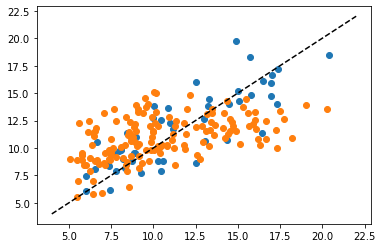

In [47]:
plt.scatter(y4_test, y4_pred)
plt.scatter(y0_test, y0_pred)
plt.plot([4,22], [4,22], 'k--')

In [50]:
mae1

1.5564970970153809